<a href="https://colab.research.google.com/github/tuli-pen/ising_mcmc_vs_propp-wilson/blob/master/Tarea_3_Fran_Tuli_Jsotop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tarea 3 Cadenas de Markov**
## *Muestreo MCMC vs Simulación perfecta aplicadas al modelo de Ising*

---

**Profesor:** Freddy Hernández-Romero

**Integrantes del grupo:**
- Juan Bernardo Soto Pescador
- Francisco José Gutiérrez Peña
- Tuli Peña Melo


## PUNTO A) Muestreo aproximado

In [ ]:
# PUNTO A) Muestreo aproximado

# Implementación del Gibbs sampler para el modelo de Ising
# Burn-in = 1000 sweeps, gap = 500 sweeps,
# 4 cadenas independientes, 25 muestras por cadena (4*25=100 muestras por beta)
# Valores: K in [10,15,20], beta in [0,0.1,...,1.0]
# Guarda resultados en CSV: una fila por muestra con metadatos y la configuración (lista aplanada)

import numpy as np
import pandas as pd
import time
import math

# Parámetros
Ks = [10, 15, 20]
betas = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
chains_per_beta = 4
samples_per_chain = 25  # 4 * 25 = 100 muestras por beta
burn_in_sweeps = 1000
gap_sweeps = 500

# Archivo de salida
output_csv = "ising_muestras_aproximadas.csv"

# Semilla (opcional)
rng = np.random.default_rng()

# Funciones auxiliares

def init_configuration(K, mode, rng):
    """
    mode: 'plus', 'minus', 'random'
    devuelve un array KxK con valores en {-1,+1}
    """
    if mode == 'plus':
        return np.ones((K, K), dtype=np.int8)
    elif mode == 'minus':
        return -np.ones((K, K), dtype=np.int8)
    elif mode == 'random':
        # Bernoulli -> map {0,1} to {-1,+1}
        return rng.choice([-1, 1], size=(K, K))
    else:
        raise ValueError("Unknown init mode")


def sweep_gibbs(config, beta, rng):
    """
    Realiza un sweep (N = K^2 actualizaciones) del Gibbs sampler.
    Actualiza en orden aleatorio (permuta de sitios) para evitar artefactos.
    """
    K = config.shape[0]
    # lista de índices plana
    idxs = np.arange(K * K)
    rng.shuffle(idxs)
    for idx in idxs:
        i = idx // K
        j = idx % K
        # vecinos con condiciones periódicas
        up = config[(i - 1) % K, j]
        down = config[(i + 1) % K, j]
        left = config[i, (j - 1) % K]
        right = config[i, (j + 1) % K]
        s = up + down + left + right  # suma de vecinos
        # probabilidad de poner +1
        if beta == 0.0:
            p_plus = 0.5
        else:
            # p(+1) = 1 / (1 + exp(-2 * beta * s))
            # evitar overflow en exp: cap el argumento
            arg = -2.0 * beta * s
            # numpy exp safe via math.exp (s small integer: -4..4)
            p_plus = 1.0 / (1.0 + math.exp(arg))
        # muestreo
        if rng.random() < p_plus:
            config[i, j] = 1
        else:
            config[i, j] = -1
    return config


def magnetization(config):
    return float(config.sum()) / config.size


# Preparar DataFrame para resultados
columns = ["K", "beta", "sample_global_idx", "chain_id", "sample_in_chain", "sweep_time", "magnetization", "spins"]
results = []

# Contadores para progreso
total_betas = len(betas)
total_K = len(Ks)
total_samples = total_K * total_betas * chains_per_beta * samples_per_chain
sample_counter = 0
start_time = time.time()

print(f"Total samples to generate: {total_samples}")

# Bucle principal
for K in Ks:
    N = K * K
    for beta in betas:
        # Preparar 4 inicializaciones distintas por beta
        init_modes = ['plus', 'minus', 'random', 'random']
        for chain_id in range(chains_per_beta):
            mode = init_modes[chain_id % len(init_modes)]
            config = init_configuration(K, mode, rng)
            sweep_clock = 0  # cuenta de sweeps transcurridos en esta cadena

            # Burn-in
            for _ in range(burn_in_sweeps):
                config = sweep_gibbs(config, beta, rng)
                sweep_clock += 1

            # Recolectar samples_per_chain muestras, separadas por gap_sweeps
            for sample_in_chain in range(samples_per_chain):
                # Avanzar gap_sweeps sweeps
                for _ in range(gap_sweeps):
                    config = sweep_gibbs(config, beta, rng)
                    sweep_clock += 1

                # Guardar la muestra actual
                spins_flat = config.flatten().astype(int)
                spins_str = " ".join(map(str, spins_flat.tolist()))
                mag = magnetization(config)
                sample_global_idx = sample_counter

                results.append({
                    "K": K,
                    "beta": beta,
                    "sample_global_idx": sample_global_idx,
                    "chain_id": chain_id,
                    "sample_in_chain": sample_in_chain,
                    "sweep_time": sweep_clock,
                    "magnetization": mag,
                    "spins": spins_str
                })

                sample_counter += 1

                # Progreso: imprimir porcentaje
                if sample_counter % 10 == 0 or sample_counter == total_samples:
                    elapsed = time.time() - start_time
                    pct = 100.0 * sample_counter / total_samples
                    eta = (elapsed / sample_counter) * (total_samples - sample_counter) if sample_counter>0 else 0
                    print(f"Progress: {sample_counter}/{total_samples} ({pct:.1f}%) - elapsed {elapsed:.1f}s - ETA {eta:.1f}s")

# Convertir a DataFrame y guardar CSV
df = pd.DataFrame(results, columns=columns)
df.to_csv(output_csv, index=False)

total_elapsed = time.time() - start_time
print(f"Finished. Total samples: {sample_counter}. CSV saved to {output_csv}. Time elapsed: {total_elapsed:.1f}s")

Total samples to generate: 3300
Progress: 10/3300 (0.3%) - elapsed 2.7s - ETA 883.3s
Progress: 20/3300 (0.6%) - elapsed 4.5s - ETA 734.6s
Progress: 30/3300 (0.9%) - elapsed 6.3s - ETA 685.2s
Progress: 40/3300 (1.2%) - elapsed 7.8s - ETA 636.8s
Progress: 50/3300 (1.5%) - elapsed 9.4s - ETA 608.7s
Progress: 60/3300 (1.8%) - elapsed 11.2s - ETA 603.2s
Progress: 70/3300 (2.1%) - elapsed 12.7s - ETA 586.1s
Progress: 80/3300 (2.4%) - elapsed 15.4s - ETA 619.6s
Progress: 90/3300 (2.7%) - elapsed 17.1s - ETA 611.5s
Progress: 100/3300 (3.0%) - elapsed 18.7s - ETA 597.0s
Progress: 110/3300 (3.3%) - elapsed 22.1s - ETA 640.9s
Progress: 120/3300 (3.6%) - elapsed 24.9s - ETA 660.8s
Progress: 130/3300 (3.9%) - elapsed 29.9s - ETA 730.2s
Progress: 140/3300 (4.2%) - elapsed 32.8s - ETA 741.0s
Progress: 150/3300 (4.5%) - elapsed 35.7s - ETA 749.6s
Progress: 160/3300 (4.8%) - elapsed 39.2s - ETA 769.4s
Progress: 170/3300 (5.2%) - elapsed 42.9s - ETA 790.7s
Progress: 180/3300 (5.5%) - elapsed 46.3s - ETA

## PUNTO B) Muestreo perfecto

In [ ]:
# PUNTO B) Muestreo perfecto

# Propp-Wilson CFTP para Ising, optimizado con PyTorch (GPU)
# - Checkerboard Gibbs updates usando conv2d para suma de vecinos
# - Ejecuta CFTP por muestra (cada muestra es exacta)
# - Guarda 100 muestras por beta y por cada K en CSV

import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import time
import math
from collections import deque
from typing import Tuple

# ---------------------------
# Parámetros (ajustables)
# ---------------------------
Ks = [10]
betas = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
samples_per_beta = 100
output_csv = "ising_muestras_exactas.csv"

# CFTP control
max_doublings = 28   # si ves tiempos enormes, reduce o aumenta según recursos
# Nota: con doubling hasta 28 => T puede alcanzar 2^28 sweeps (sólo útil si no llegas a ese tope)

# Device (GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------------------------
# Helpers: neighbors kernel, masks
# ---------------------------

def make_neighbor_kernel(device):
    # kernel 3x3 con 1 en vecinos 4-adj y 0 centro
    k = torch.tensor([[[[0.0, 1.0, 0.0],
                        [1.0, 0.0, 1.0],
                        [0.0, 1.0, 0.0]]]], device=device)  # shape [out_ch=1, in_ch=1, 3,3]
    return k

def prepare_checkerboard_masks(K, device):
    # masks with shape [1,1,K,K], float tensor 1.0 on sites to update, 0.0 elsewhere
    inds = torch.arange(K, device=device)
    ii = inds.view(K,1).repeat(1,K)
    jj = inds.view(1,K).repeat(K,1)
    checker = ((ii + jj) % 2 == 0)  # even mask
    even_mask = checker.to(dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # [1,1,K,K]
    odd_mask = (1.0 - even_mask)
    return even_mask, odd_mask

# ---------------------------
# Core update: Gibbs checkerboard step
# ---------------------------

def neighbor_sum(config: torch.Tensor, kernel: torch.Tensor) -> torch.Tensor:
    """
    config: tensor shape [1,1,K,K], values in {-1, +1}
    kernel: neighbor kernel shape [1,1,3,3]
    returns sum of 4-neighbors shape [1,1,K,K]
    uses circular padding for periodic BC.
    """
    # pad circular then conv
    # F.pad expects (pad_left, pad_right, pad_top, pad_bottom)
    cfg_padded = F.pad(config, (1,1,1,1), mode='circular')
    s = F.conv2d(cfg_padded, kernel, padding=0)
    return s

def gibbs_checkerboard_update(config: torch.Tensor,
                              u: torch.Tensor,
                              beta: float,
                              mask: torch.Tensor,
                              kernel: torch.Tensor) -> torch.Tensor:
    """
    Aplica una media-actualización (solo sitios indicados por mask).
    - config: [1,1,K,K], float -1/+1
    - u: [1,1,K,K] uniform in [0,1) (random numbers for deciding)
    - beta: float
    - mask: [1,1,K,K] with 1.0 on sites to update, 0.0 elsewhere
    - kernel: neighbor sum kernel
    Devuelve config actualizado (tensor nuevo o en sitio).
    """
    # compute neighbor sum
    s = neighbor_sum(config, kernel)  # values in -4..4
    if beta == 0.0:
        p_plus = 0.5 * torch.ones_like(s)
    else:
        # p(+1) = 1/(1 + exp(-2 beta s))
        # Using torch.sigmoid(2*beta*s) is more stable since sigmoid(x) = 1/(1+exp(-x))
        p_plus = torch.sigmoid(2.0 * beta * s)
    # propose new spins for all sites
    proposed = torch.where(u < p_plus, torch.tensor(1.0, device=device), torch.tensor(-1.0, device=device))
    # keep old on non-mask positions
    new_config = torch.where(mask.bool(), proposed, config)
    return new_config

# ---------------------------
# Build sweeps (each sweep = two half-updates: even then odd)
# ---------------------------

def generate_sweep_pair(K: int) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Genera dos tensores uniformes shape [1,1,K,K] en device:
    (u_even, u_odd) para la sweep.
    (llamado por CFTP; se generan en GPU para aprovechar).
    """
    u_even = torch.rand((1,1,K,K), device=device)
    u_odd  = torch.rand((1,1,K,K), device=device)
    return u_even, u_odd

# ---------------------------
# CFTP (per muestra) - GPU-accelerated
# ---------------------------

def run_cftp_one_sample_gpu(K: int, beta: float, kernel: torch.Tensor,
                            even_mask: torch.Tensor, odd_mask: torch.Tensor,
                            max_doublings_local: int = 28) -> Tuple[torch.Tensor, int]:
    """
    Ejecuta Propp-Wilson (CFTP) en GPU para devolver una muestra exacta.
    Devuelve (sample_config_flat_tensor_int8, coalescence_T_sweeps)
    - sample config as 1D torch int tensor length K*K of -1/+1
    """
    N = K * K
    # inicializaciones extremas [1,1,K,K]
    top = torch.ones((1,1,K,K), dtype=torch.float32, device=device)
    bottom = -torch.ones((1,1,K,K), dtype=torch.float32, device=device)

    # deque de sweeps: cada elemento es (u_even [1,1,K,K], u_odd [1,1,K,K])
    updates = deque()
    T = 1
    # generar inicial T sweeps y añadir (más antiguo a la izquierda)
    for _ in range(T):
        updates.appendleft(generate_sweep_pair(K))

    doubling_count = 0
    while True:
        # Make copies to simulate evolution from time -T..-1
        top_c = top.clone()
        bottom_c = bottom.clone()
        # Apply sweeps left->right (older -> newer)
        for (u_even, u_odd) in updates:
            # even half-update
            top_c = gibbs_checkerboard_update(top_c, u_even, beta, even_mask, kernel)
            bottom_c = gibbs_checkerboard_update(bottom_c, u_even, beta, even_mask, kernel)
            # odd half-update
            top_c = gibbs_checkerboard_update(top_c, u_odd, beta, odd_mask, kernel)
            bottom_c = gibbs_checkerboard_update(bottom_c, u_odd, beta, odd_mask, kernel)

        # Check coalescence
        if torch.equal(top_c, bottom_c):
            # coalesced: result is top_c (or bottom_c)
            sample = top_c.squeeze().reshape(-1).to(dtype=torch.int8).cpu()  # move to CPU and int8
            return sample, T
        # else: double T by prepending T new sweeps
        doubling_count += 1
        if doubling_count > max_doublings_local:
            raise RuntimeError(f"CFTP did not coalesce after {doubling_count} doublings (T approx {T}). Increase max_doublings or adjust strategy.")
        for _ in range(T):
            updates.appendleft(generate_sweep_pair(K))
        T *= 2

# ---------------------------
# Bucle principal: generar todas las muestras
# ---------------------------

rows = []
total_tasks = len(Ks) * len(betas) * samples_per_beta
task_counter = 0
tic = time.time()

# Precreate kernel and masks per K to avoid repeated allocations
kernel_cache = {}
mask_cache = {}

print(f"Starting CFTP on device={device}. Total exact samples to generate: {total_tasks}")

for K in Ks:
    kernel = make_neighbor_kernel(device)
    even_mask, odd_mask = prepare_checkerboard_masks(K, device)
    kernel_cache[K] = kernel
    mask_cache[K] = (even_mask, odd_mask)

for K in Ks:
    kernel = kernel_cache[K]
    even_mask, odd_mask = mask_cache[K]
    for beta in betas:
        for sidx in range(samples_per_beta):
            # run single-sample CFTP on GPU
            try:
                sample_flat_tensor, T_used = run_cftp_one_sample_gpu(K, beta, kernel, even_mask, odd_mask, max_doublings_local=max_doublings)
            except RuntimeError as e:
                print(f"[WARN] Sample failed for K={K}, beta={beta}, sample_idx={sidx}: {e}")
                raise

            # compute magnetization and serialize spins
            mag = float(sample_flat_tensor.sum().item()) / (K*K)
            spins_str = " ".join(map(str, sample_flat_tensor.tolist()))
            rows.append({
                "K": K,
                "beta": beta,
                "sample_idx": sidx,
                "coalescence_T": int(T_used),
                "magnetization": mag,
                "spins": spins_str
            })

            task_counter += 1
            # progreso
            elapsed = time.time() - tic
            pct = 100.0 * task_counter / total_tasks
            eta = (elapsed / task_counter) * (total_tasks - task_counter) if task_counter>0 else 0
            print(f"Progress: {task_counter}/{total_tasks} ({pct:.1f}%) - elapsed {elapsed:.1f}s - ETA {eta:.1f}s")

# Guardar CSV al final
df = pd.DataFrame(rows, columns=["K","beta","sample_idx","coalescence_T","magnetization","spins"])
df.to_csv(output_csv, index=False)
print(f"Finished. CSV saved to: {output_csv}. Total time: {time.time()-tic:.1f}s")

Coalescence time datos:
count    1.730000e+03
mean     1.443511e+05
std      1.089291e+06
min      1.000000e+00
25%      4.000000e+00
50%      1.600000e+01
75%      1.280000e+02
max      1.677722e+07
Name: coalescence_T, dtype: float64


/tmp/ipykernel_6741/4034867871.py:94: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = ax.boxplot(coalescence_data, labels=labels, patch_artist=True)


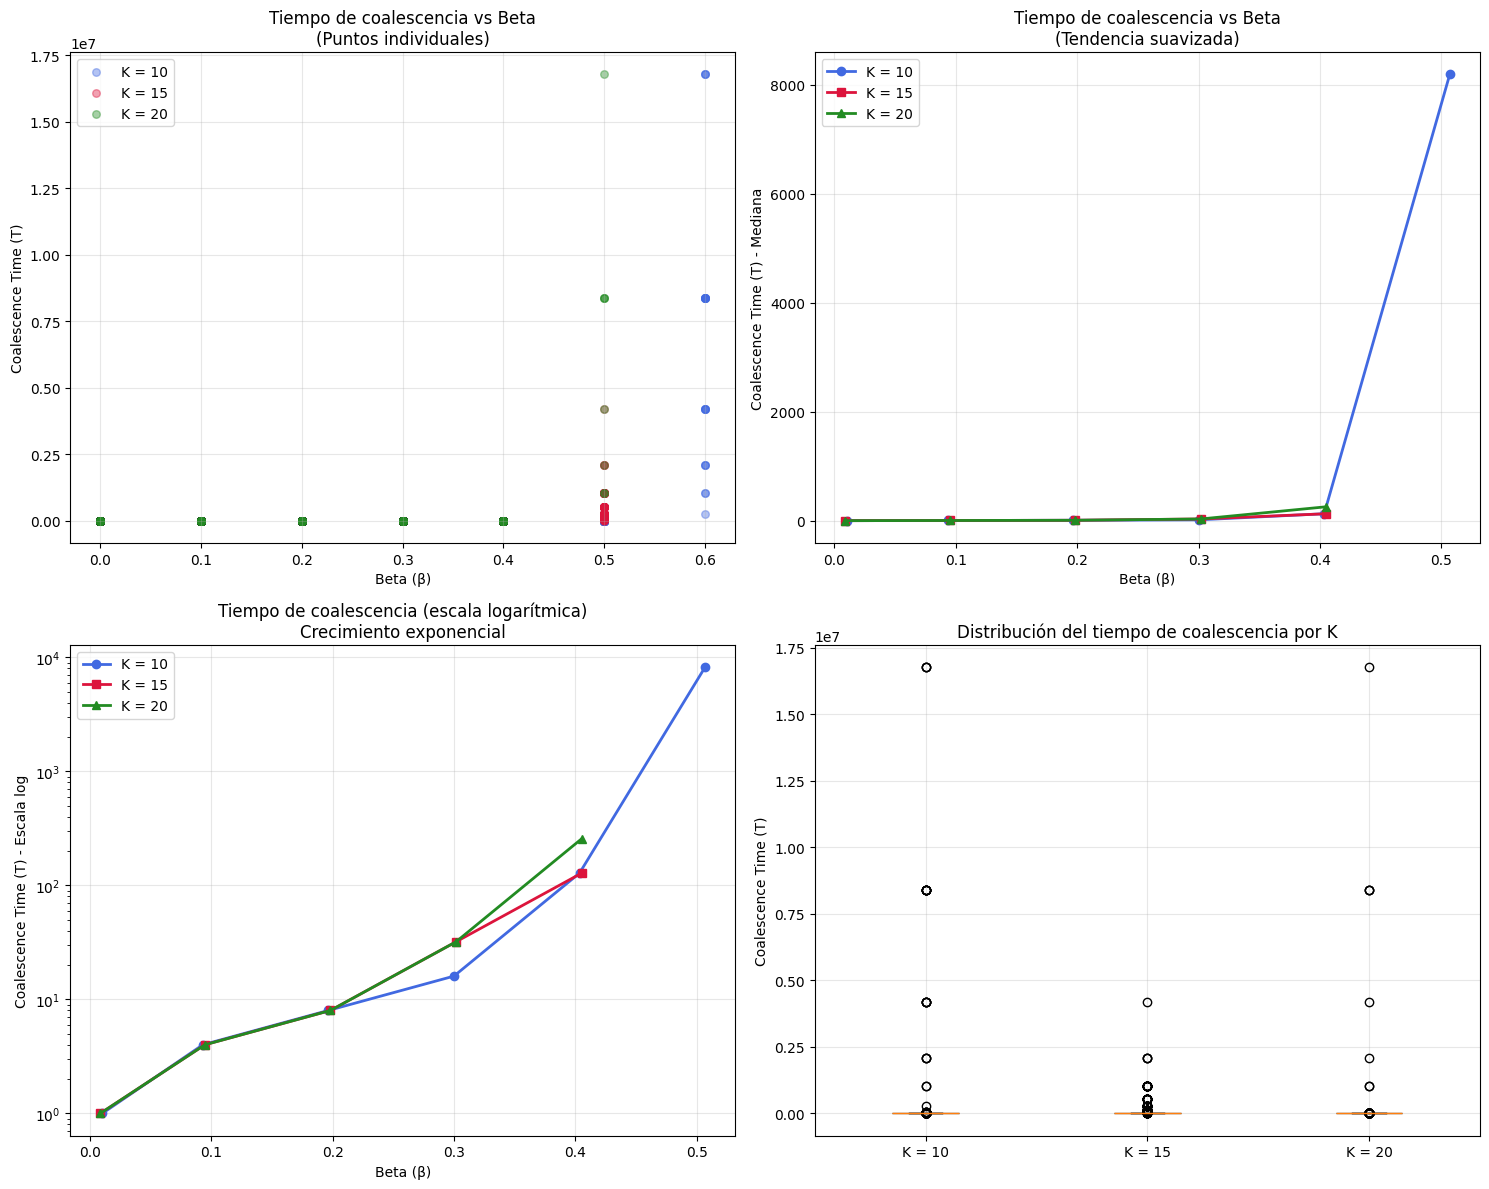

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d

df = pd.read_csv('ising_cftp_seeds_perfect_samples.csv')
df_clean = df.dropna(subset=['magnetization', 'coalescence_T']).copy()

print(f"Coalescence time datos:")
print(df_clean['coalescence_T'].describe())

# Colores para cada valor de K
colors = {10: 'royalblue', 15: 'crimson', 20: 'forestgreen'}
markers = {10: 'o', 15: 's', 20: '^'}

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Coalescence time vs Beta (todos los puntos)
ax = axes[0, 0]
for K in sorted(df_clean['K'].unique()):
    data_K = df_clean[df_clean['K'] == K]
    ax.scatter(data_K['beta'], data_K['coalescence_T'], 
               alpha=0.4, label=f'K = {K}', color=colors[K], s=30)
ax.set_xlabel('Beta (β)')
ax.set_ylabel('Coalescence Time (T)')
ax.set_title('Tiempo de coalescencia vs Beta\n(Puntos individuales)')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Coalescence time vs Beta (comportamiento)
ax = axes[0, 1]
for K in sorted(df_clean['K'].unique()):
    data_K = df_clean[df_clean['K'] == K].sort_values('beta')
    if len(data_K) > 5:
        # Use median in bins to reduce noise
        bins = np.linspace(data_K['beta'].min(), data_K['beta'].max(), 30)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        bin_medians = []
        for i in range(len(bins)-1):
            mask = (data_K['beta'] >= bins[i]) & (data_K['beta'] < bins[i+1])
            if mask.sum() > 0:
                bin_medians.append(data_K[mask]['coalescence_T'].median())
            else:
                bin_medians.append(np.nan)
        
        # Remove NaN values for plotting
        valid_mask = ~np.isnan(bin_medians)
        ax.plot(bin_centers[valid_mask], np.array(bin_medians)[valid_mask], 
                marker=markers[K], markersize=6, linewidth=2, 
                label=f'K = {K}', color=colors[K])

ax.set_xlabel('Beta (β)')
ax.set_ylabel('Coalescence Time (T) - Mediana')
ax.set_title('Tiempo de coalescencia vs Beta\n(Tendencia suavizada)')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Escala logarítmica para ver comportamiento exponencial
ax = axes[1, 0]
for K in sorted(df_clean['K'].unique()):
    data_K = df_clean[df_clean['K'] == K].sort_values('beta')
    if len(data_K) > 5:
        # Use median in bins
        bins = np.linspace(data_K['beta'].min(), data_K['beta'].max(), 30)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        bin_medians = []
        for i in range(len(bins)-1):
            mask = (data_K['beta'] >= bins[i]) & (data_K['beta'] < bins[i+1])
            if mask.sum() > 0:
                bin_medians.append(data_K[mask]['coalescence_T'].median())
            else:
                bin_medians.append(np.nan)
        
        valid_mask = ~np.isnan(bin_medians)
        ax.semilogy(bin_centers[valid_mask], np.array(bin_medians)[valid_mask], 
                    marker=markers[K], markersize=6, linewidth=2, 
                    label=f'K = {K}', color=colors[K])

ax.set_xlabel('Beta (β)')
ax.set_ylabel('Coalescence Time (T) - Escala log')
ax.set_title('Tiempo de coalescencia (escala logarítmica)\nCrecimiento exponencial')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Distribución de los coalescence times dependiendo de K
ax = axes[1, 1]
coalescence_data = []
labels = []
for K in sorted(df_clean['K'].unique()):
    data_K = df_clean[df_clean['K'] == K]['coalescence_T']
    coalescence_data.append(data_K)
    labels.append(f'K = {K}')

boxplot = ax.boxplot(coalescence_data, labels=labels, patch_artist=True)

for patch, color in zip(boxplot['boxes'], [colors[10], colors[15], colors[20]]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('Coalescence Time (T)')
ax.set_title('Distribución del tiempo de coalescencia por K')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## PUNTO C) Visualización magnetización

Usando el sampling aproximado (logrado con Python) y el sampling perfecto (con el método de sandwiching y el algoritmo de Propp-Wilson en un archivo c adicional).

Podemos calcular la magnetización de una configuración con la siguiente fórmula:
$$M(\eta)=\frac{1}{\mid V_{K} \mid}\sum_{x \in V_{K}}\eta_{x}$$

Lo cual significa: "*La magnetización de una configuración $\eta$ está dada por el número de partículas posibles $\mid V_{K} \mid$ y los valores (spins) de cada una de las partículas en la configuración ($\eta_{x}$)*".

In [13]:
# PUNTO C) Estimación magnetización

import numpy as np
import pandas as pd
import time
import math

# Cargamos los csvs que contienen las muestras aproximadas y exactas
approximate_sample = pd.read_csv("ising_muestras_aproximadas.csv")
exact_sample = pd.read_csv("ising_cftp_seeds_perfect_samples.csv")

print(exact_sample.tail(400))

       K  beta  sample_idx  attempt_final  coalescence_T  magnetization  \
2900  20   0.7           4              1             -1            NaN   
2901  20   0.7          12              0             -1            NaN   
2902  20   0.7          13              0             -1            NaN   
2903  20   0.7          14              0             -1            NaN   
2904  20   0.7          15              0             -1            NaN   
...   ..   ...         ...            ...            ...            ...   
3295  20   1.0           7              1             -1            NaN   
3296  20   1.0           4              1             -1            NaN   
3297  20   1.0           6              1             -1            NaN   
3298  20   1.0          11              1             -1            NaN   
3299  20   1.0          10              1             -1            NaN   

             spins        status  elapsed_s  
2900  BETA_TIMEOUT    930.437000        NaN  
2901   

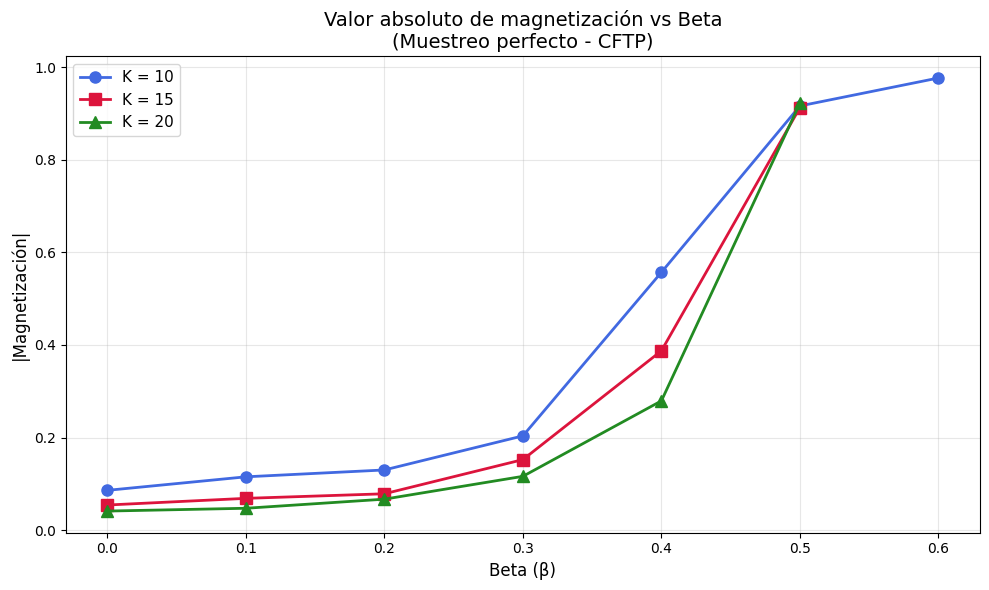

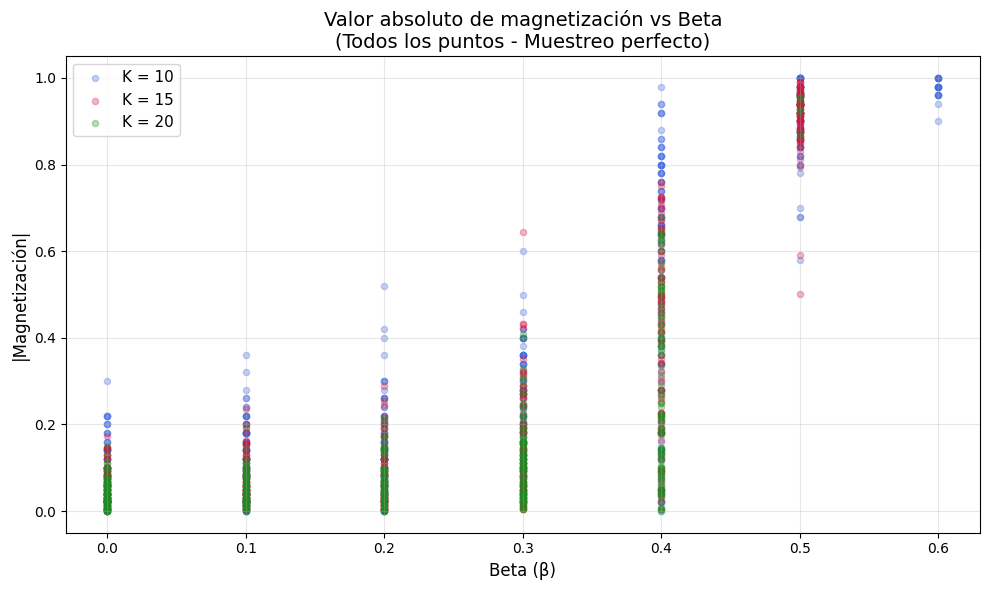

In [ ]:
# Visualización: Valor absoluto de magnetización vs beta
# Diferentes colores para cada K

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Leer los datos
df = pd.read_csv('ising_cftp_seeds_perfect_samples.csv')

# Calcular el valor absoluto de la magnetización
df['abs_magnetization'] = df['magnetization'].abs()

# Agrupar por K y beta, calculando la media del valor absoluto de magnetización
# (también podrías usar mediana u otro estadístico)
summary = df.groupby(['K', 'beta'])['abs_magnetization'].mean().reset_index()

# Crear la figura
plt.figure(figsize=(10, 6))

# Colores diferentes para cada K
colors = {10: 'royalblue', 15: 'crimson', 20: 'forestgreen'}
markers = {10: 'o', 15: 's', 20: '^'}

# Plotear para cada K
for K in sorted(df['K'].unique()):
    data_K = summary[summary['K'] == K]
    plt.plot(data_K['beta'], data_K['abs_magnetization'], 
             marker=markers[K], label=f'K = {K}', 
             color=colors[K], linewidth=2, markersize=8)

plt.xlabel('Beta (β)', fontsize=12)
plt.ylabel('|Magnetización|', fontsize=12)
plt.title('Valor absoluto de magnetización vs Beta\n(Muestreo perfecto - CFTP)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# También mostrar todos los puntos individuales (scatter plot)
plt.figure(figsize=(10, 6))
for K in sorted(df['K'].unique()):
    data_K = df[df['K'] == K]
    plt.scatter(data_K['beta'], data_K['abs_magnetization'], 
                alpha=0.3, label=f'K = {K}', 
                color=colors[K], s=20)

plt.xlabel('Beta (β)', fontsize=12)
plt.ylabel('|Magnetización|', fontsize=12)
plt.title('Valor absoluto de magnetización vs Beta\n(Todos los puntos - Muestreo perfecto)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


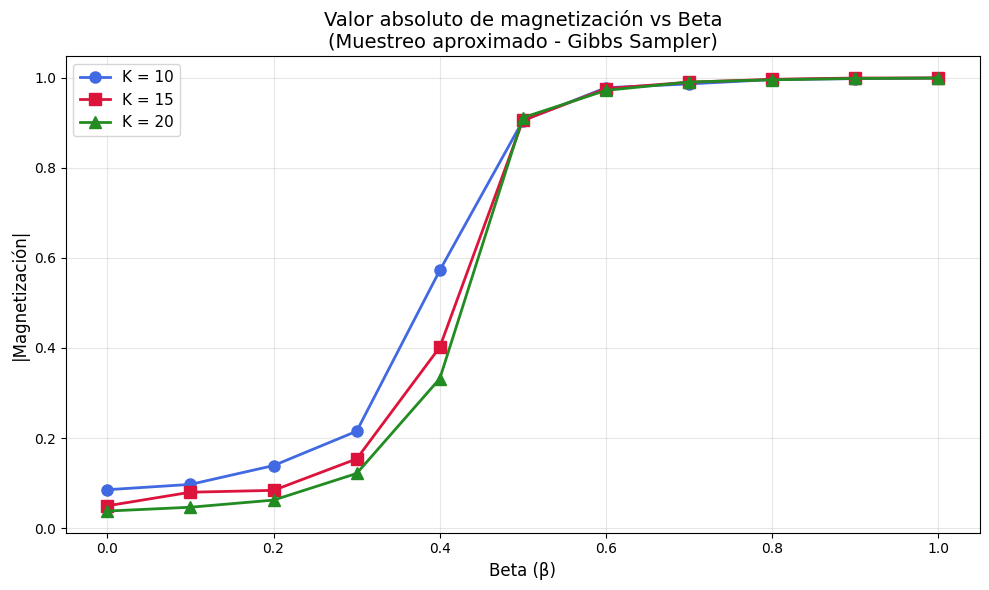

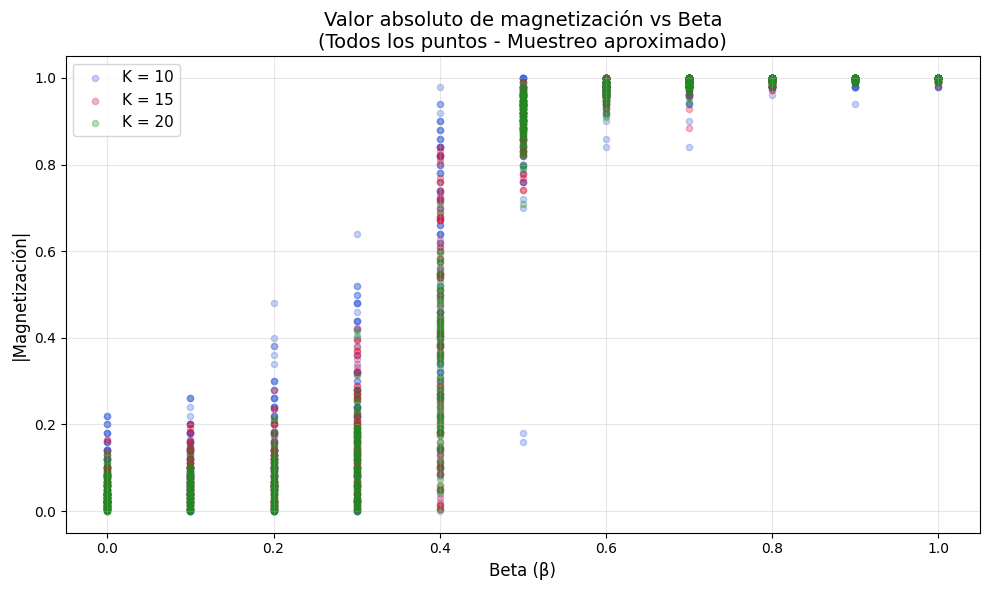

In [17]:
# Visualización: Valor absoluto de magnetización vs beta
# Diferentes colores para cada K

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Leer los datos
df = pd.read_csv('ising_muestras_aproximadas.csv')

# Calcular el valor absoluto de la magnetización
df['abs_magnetization'] = df['magnetization'].abs()

# Agrupar por K y beta, calculando la media del valor absoluto de magnetización
# (también podrías usar mediana u otro estadístico)
summary = df.groupby(['K', 'beta'])['abs_magnetization'].mean().reset_index()

# Crear la figura
plt.figure(figsize=(10, 6))

# Colores diferentes para cada K
colors = {10: 'royalblue', 15: 'crimson', 20: 'forestgreen'}
markers = {10: 'o', 15: 's', 20: '^'}

# Plotear para cada K
for K in sorted(df['K'].unique()):
    data_K = summary[summary['K'] == K]
    plt.plot(data_K['beta'], data_K['abs_magnetization'], 
             marker=markers[K], label=f'K = {K}', 
             color=colors[K], linewidth=2, markersize=8)

plt.xlabel('Beta (β)', fontsize=12)
plt.ylabel('|Magnetización|', fontsize=12)
plt.title('Valor absoluto de magnetización vs Beta\n(Muestreo aproximado - Gibbs Sampler)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# También mostrar todos los puntos individuales (scatter plot)
plt.figure(figsize=(10, 6))
for K in sorted(df['K'].unique()):
    data_K = df[df['K'] == K]
    plt.scatter(data_K['beta'], data_K['abs_magnetization'], 
                alpha=0.3, label=f'K = {K}', 
                color=colors[K], s=20)

plt.xlabel('Beta (β)', fontsize=12)
plt.ylabel('|Magnetización|', fontsize=12)
plt.title('Valor absoluto de magnetización vs Beta\n(Todos los puntos - Muestreo aproximado)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()